**Import Python Packages**

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

## Demographic Data Processing

The functions below retrieve block level data for a state using the state fips code from census API, then retrieves data from appropriate
columns in GEOID, convert to .csv to easily manipulate individual state data

In [2]:
#code chunk by Melisande Teng 

variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [3]:
#Specify MI code to pull demographic data at block level
demographic_block_data = block_data_for_state('26')
#Now we have the block data by county 

**Read in shapefile**

In [4]:
#Read Census block shapefiles
#Source: (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks)
blocks_2010_shp = gpd.read_file("tl_2010_26_tabblock10/tl_2010_26_tabblock10.shp")

In [5]:
#Given that the demographic df and demographic gdf have the same number of rows, want 
#to check to see if geoids overlap
d_df = demographic_block_data
d_gdf = blocks_2010_shp
gdf_set = set(d_gdf.GEOID10.str.lower().unique())
df_set = set(d_df.geoid.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [6]:
len(d_df)

329885

In [7]:
len(df_set.intersection(gdf_set))
#So, the length of the set is the same as the number of geoids
#indicates they all match, so should be good to join

329885

**Join data with shape (block level demographic data with block level shapefile)**

In [8]:
demographic_block = d_gdf.merge(d_df, how = 'inner', left_on = 'GEOID10', right_on = 'geoid', indicator = True)

In [9]:
print(len(demographic_block.GEOID10))
print(len(d_gdf.GEOID10))
print(demographic_block.TOTPOP.sum())
print(d_df.TOTPOP.sum())

329885
329885
9883640
9883640


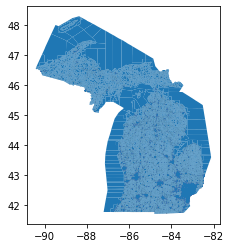

In [10]:
demographic_block.plot()

**Prorate demographic and Voting Population data from census block level to precinct level**
< "Prorate" 

In [11]:
#2016 PRECINCTS
precincts = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")

In [12]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("./MI_precincts/MI_precincts.shp")

**Demographic and Voting Pop Data from Block Level to Precinct Level**

In [13]:
precincts.crs

<Projected CRS: EPSG:3078>
Name: NAD83 / Michigan Oblique Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Michigan
- bounds: (-90.42, 41.69, -82.13, 48.32)
Coordinate Operation:
- name: Michigan Oblique Mercator (meters)
- method: Hotine Oblique Mercator (variant A)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
proj =  {'init':'epsg:4326'}
proj = precincts.crs
precincts = precincts.to_crs(proj)
demographic_block = demographic_block.to_crs(proj)

In [15]:
demographic_block.columns = demographic_block.columns.str.strip()

In [16]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."


In [17]:
set(mggg_final_shp.columns) - set(demographic_block.columns)

{'CD',
 'CountyFips',
 'ElectionYe',
 'HDIST',
 'Jurisdicti',
 'Label',
 'PRES16D',
 'PRES16G',
 'PRES16L',
 'PRES16R',
 'SENDIST',
 'ShapeSTLen',
 'VTD',
 'VTD2016_x',
 'county_fip',
 'county_lat',
 'county_lon',
 'county_nam',
 'jurisdic_1',
 'precinct'}

In [18]:
precincts['geometry'] = precincts.buffer(0)

In [19]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

demo_variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

demographic_precinct = maup.assign(demographic_block, precincts)

In [20]:
precincts[demo_variables] = demographic_block[demo_variables].groupby(demographic_precinct).sum()

In [21]:
precincts.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HISP,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,57,1572,38,1330,75,2,20,0,6,101
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,57,1992,43,1760,41,3,16,0,1,128
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,64,2283,48,2024,43,2,30,1,3,132
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",...,50,1307,35,1160,33,1,8,2,6,62
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",...,29,1485,21,1316,27,2,16,0,0,103


In [22]:
precincts.TOTPOP.sum()

9883640

**Assign precincts to Senate Districts using maup**

In [23]:
#Senate Districts
####MGGG includes senate as "SENDIST" to present the 2011 enacted senate district IDs 
senate_districts = gpd.read_file("tl_2011_26_sldu/tl_2011_26_sldu.shp")

In [24]:
senate_districts.head()

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,032,26032,State Senate District 32,LU,2010,G5210,N,3544598561,49207378,+43.3144336,-084.2815131,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,021,26021,State Senate District 21,LU,2010,G5210,N,4132805449,3916054903,+42.0800198,-086.4581424,"POLYGON ((-85.96515 41.75996, -85.96795 41.759..."
2,26,020,26020,State Senate District 20,LU,2010,G5210,N,1634946080,54505667,+42.2411689,-085.5647665,"POLYGON ((-85.76400 42.13104, -85.76424 42.141..."
3,26,037,26037,State Senate District 37,LU,2010,G5210,N,14964533699,15423069409,+45.7073805,-084.6195485,"POLYGON ((-85.33291 44.79862, -85.33290 44.798..."
4,26,024,26024,State Senate District 24,LU,2010,G5210,N,5059533913,2683914021,+42.5984030,-085.8112138,"POLYGON ((-85.99465 42.41896, -85.99596 42.418..."


In [25]:
senate_districts = senate_districts.to_crs(proj)

In [26]:
sd_precinct = maup.assign(precincts, senate_districts)

In [27]:
print(sd_precinct.unique())
print(sd_precinct.head())

[30  8  5  4  3 10  7  1  6 22 19 20 21  0 15 16 18  2 36 34 35 37 23 24
 25  9 17 33 32 29 26 27 31 28 13 11 14 12]
0    30
1    30
2    30
3    30
4    30
dtype: int64


In [28]:
#no '0' district, so add 1 to IDs
sd_precinct = sd_precinct + 1.0

In [29]:
# Assign senate districts to precinct shapefile
precincts['SENDIST'] = sd_precinct

In [30]:
#confirm what it looks like
precincts['SENDIST'].nunique()

38

**Assign house districts to precincts using maup**

In [31]:
#State House of Representatives
#MGGG uses "HDIST" to represent 2011 enacted house plans
congressional_districts = gpd.read_file("tl_2011_26_sldl/tl_2011_26_sldl.shp")

In [32]:
congressional_districts.head()

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,098,26098,State House District 98,LL,2010,G5220,N,1112688263,20224890,+43.4119307,-084.2345730,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,094,26094,State House District 94,LL,2010,G5220,N,982458210,19105502,+43.3030887,-083.9582146,"POLYGON ((-84.17061 43.45253, -84.17061 43.462..."
2,26,095,26095,State House District 95,LL,2010,G5220,N,292245702,9872663,+43.3895144,-083.9174552,"POLYGON ((-83.81667 43.34949, -83.81666 43.349..."
3,26,080,26080,State House District 80,LL,2010,G5220,N,1756368818,3819297751,+42.2806954,-086.3376517,"POLYGON ((-85.99596 42.41897, -85.99465 42.418..."
4,26,081,26081,State House District 81,LL,2010,G5220,N,1433103685,284194383,+42.9909507,-082.8390301,"POLYGON ((-82.41988 43.00231, -82.42273 43.000..."


In [33]:
congressional_districts = congressional_districts.to_crs(proj)

In [34]:
cd_precinct = maup.assign(precincts, congressional_districts)

In [35]:
# Add 1 to assignments
cd_precinct += 1

cd_precinct

0       76
1       76
2       76
3       92
4       92
        ..
4805    59
4806    59
4807    59
4808    59
4809    59
Length: 4810, dtype: int64

In [36]:
precincts['HDIST'] = cd_precinct

In [37]:
precincts.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips', 'Jurisdicti', 'ElectionYe',
       'Label', 'ShapeSTAre', 'ShapeSTLen', 'geometry', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'SENDIST', 'HDIST'],
      dtype='object')

In [38]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("MI_precincts/MI_precincts.shp")

In [39]:
mggg_final_shp.shape

(4809, 44)

## Presidential ELECTION PROCESSING

**Import 2016 Election Data: Shape Files (gdf)**

In [40]:
#Precinct and congressional district shapefiles from State of MI GIS portal
#Source: State of Michigan GIS Open Data Portal(http://gis-michigan.opendata.arcgis.com/datasets/2016-voting-precincts?geometry=94.224%2C43.115%2C-91.752%2C84.203)
precincts_shp_2016 = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")

In [41]:
precincts_shp_2016.shape  # all geo information

(4810, 10)

**Modify the labels** to match gdf (shapefile) to df (election results)

In [42]:
# combine to use multiple variables:
def precinct_mod(row):
    label = row['Label']
    vtd2016 = row['VTD2016']
    
    if 'City of' in label:
        replace_label = label.replace("City of", "")
        replace_label = replace_label.lstrip() + " City"
        
    elif 'Township' in label:
        replace_label = label.upper()
        
    ward = vtd2016[-5:-3]
    precinct_num = vtd2016[-3:].lstrip("0")
    if ward != '00':
        ward = ward.lstrip("0")
        replace_label = replace_label.lstrip() + "; Ward " + ward + "; Precinct " + precinct_num
    elif ward == '00':
        replace_label = replace_label.lstrip() + "; " + precinct_num
    return replace_label.upper()
         
        #switched to upper case to match the df

Test of the modification

In [43]:
precincts_shp_2016.apply(precinct_mod, axis = 1)

0         DEARBORN CITY; 1
1         DEARBORN CITY; 2
2         DEARBORN CITY; 3
3         DEARBORN CITY; 4
4         DEARBORN CITY; 5
               ...        
4805     GENOA TOWNSHIP; 7
4806    OCEOLA TOWNSHIP; 5
4807    OCEOLA TOWNSHIP; 1
4808    OCEOLA TOWNSHIP; 2
4809    OCEOLA TOWNSHIP; 4
Length: 4810, dtype: object

In [44]:
gdf = precincts_shp_2016
gdf['Label'] = gdf.apply(precinct_mod, axis = 1)
gdf.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,DEARBORN CITY; 4,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,DEARBORN CITY; 5,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."


In [45]:
gdf.to_csv('2016_Voting_Precincts.csv')

### Reading 2016 Election Data Files/dataframe (df)

In [46]:
#2016 precinct-level election data - all offices all states
precinct_election_data = pd.read_csv("2016-precinct-president.csv", 
                                     encoding='ISO-8859-1',
                                     dtype = {"county_name" : "str","precinct" : "str","district" : "str", "county_fips": "str"},
                                    low_memory=False)
#specified datatype for specific columns due to error message

In [47]:
precinct_election_data.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Filter to return data only for MI
mi_precinct_election = precinct_election_data[precinct_election_data.state_fips == 26]

In [49]:
mi_precinct_election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [50]:
mi_precinct_election['county_fips'].unique()

array(['26001', '26003', '26005', '26007', '26009', '26011', '26013',
       '26015', '26017', '26019', '26021', '26023', '26025', '26027',
       '26029', '26031', '26033', '26035', '26037', '26039', '26041',
       '26043', '26045', '26047', '26049', '26051', '26053', '26055',
       '26057', '26059', '26061', '26063', '26065', '26067', '26069',
       '26071', '26073', '26075', '26077', '26079', '26081', '26083',
       '26085', '26087', '26089', '26091', '26093', '26095', '26097',
       '26099', '26101', '26103', '26105', '26107', '26109', '26111',
       '26113', '26115', '26117', '26119', '26121', '26123', '26125',
       '26127', '26129', '26131', '26133', '26135', '26137', '26139',
       '26141', '26143', '26145', '26151', '26153', '26155', '26147',
       '26149', '26157', '26159', '26161', '26163', '26165'], dtype=object)

Testing out dataset, investigating

In [51]:
mi_precinct_election['precinct']

1058001          HAWES TOWNSHIP; 1
1058002          HAWES TOWNSHIP; 1
1058003          HAWES TOWNSHIP; 1
1058004          HAWES TOWNSHIP; 1
1058005          HAWES TOWNSHIP; 1
                    ...           
1123997    SPRINGVILLE TOWNSHIP; 1
1123998    SPRINGVILLE TOWNSHIP; 1
1123999    SPRINGVILLE TOWNSHIP; 1
1124000    SPRINGVILLE TOWNSHIP; 1
1124001    SPRINGVILLE TOWNSHIP; 1
Name: precinct, Length: 66001, dtype: object

In [52]:
mi_precinct_election['precinct'].nunique()

4794

In [53]:
#Number of unique precincts in each county 
foo = mi_precinct_election.groupby('county_name').precinct.nunique()
foo
#foo is a variable used to represent an unspecified entity

county_name
Alcona County         13
Alger County          11
Allegan County        46
Alpena County         18
Antrim County         17
                    ... 
Tuscola County        32
Van Buren County      34
Washtenaw County     142
Wayne County        1172
Wexford County        21
Name: precinct, Length: 83, dtype: int64

In [54]:
mi_precinct_election.office.unique() # Test to make sure we are only looking at presidential race

array(['US President'], dtype=object)

Pivot df

In [55]:
mi_party = mi_precinct_election[
    (mi_precinct_election.party == 'democratic')|
    (mi_precinct_election.party == 'republican')|
    (mi_precinct_election.party == 'libertarian')|
    (mi_precinct_election.party == 'green')]



In [56]:
df = mi_pivot = mi_party.pivot_table(index = ['county_name','county_fips','precinct'],
                         columns = ['party'],
                        values = ['votes'],
                         aggfunc = 'sum').reset_index()
#"reset_index" turns assigned indices into columns so that mask can be applied


Testing out dataset, investigating

In [57]:
#See how the election data is presented for example county
newdf = df[df['county_name'] == 'Alger County']
newdf

county_name county_fips                  precinct      votes        \
party                                                     democratic green   
13     Alger County       26003      AU TRAIN TOWNSHIP; 1        199     6   
14     Alger County       26003          BURT TOWNSHIP; 1        101     6   
15     Alger County       26003  GRAND ISLAND TOWNSHIP; 1         15     0   
16     Alger County       26003     LIMESTONE TOWNSHIP; 1         75     3   
17     Alger County       26003       MATHIAS TOWNSHIP; 1        111     3   
18     Alger County       26003          MUNISING CITY; 1        441    23   
19     Alger County       26003      MUNISING TOWNSHIP; 1        166     6   
20     Alger County       26003      MUNISING TOWNSHIP; 2        158     6   
21     Alger County       26003         ONOTA TOWNSHIP; 1        121     4   
22     Alger County       26003    ROCK RIVER TOWNSHIP; 1        276    10   
23     Alger County       26003   Statistical Adjustments          0     0   

                              
party libertarian republican  
13             28        396  
14             16        200  
15              2          9  
16              7        135  
17             11        108  
18             42        518  
19             18        345  
20             13        422  
21             13        138  
22             27        314  
23              0          0

**Remove Statistical Adjustment** rows from dataset to just get the votes

In [58]:
mask = df[df.precinct == "Statistical Adjustments"]
mask.shape

(56, 7)

In [59]:
#mask to remove statistical adjustment - filter on false
remove_stat_adjust = df[(df.precinct != 'Statistical Adjustments')]
remove_stat_adjust

county_name county_fips                  precinct      votes        \
party                                                       democratic green   
0       Alcona County       26001        ALCONA TOWNSHIP; 1        199     2   
1       Alcona County       26001     CALEDONIA TOWNSHIP; 1        178     4   
2       Alcona County       26001        CURTIS TOWNSHIP; 1        214    13   
3       Alcona County       26001     GREENBUSH TOWNSHIP; 1        256     4   
4       Alcona County       26001        GUSTIN TOWNSHIP; 1         80     6   
...               ...         ...                       ...        ...   ...   
5071   Wexford County       26165         SELMA TOWNSHIP; 1        322    14   
5072   Wexford County       26165        SLAGLE TOWNSHIP; 1         92     0   
5073   Wexford County       26165  SOUTH BRANCH TOWNSHIP; 1         76     3   
5074   Wexford County       26165   SPRINGVILLE TOWNSHIP; 1        176    10   
5076   Wexford County       26165       WEXFORD TOWNSHIP; 1        110     7   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401  
3              22        501  
4              16        249  
...           ...        ...  
5071           36        729  
5072           12        179  
5073            5        127  
5074           28        494  
5076           17        357  

[5021 rows x 7 columns]

In [60]:
remove_stat_adjust[(remove_stat_adjust.county_name == 'Alcona County')]

county_name county_fips                              precinct  \
party                                                                    
0      Alcona County       26001                    ALCONA TOWNSHIP; 1   
1      Alcona County       26001                 CALEDONIA TOWNSHIP; 1   
2      Alcona County       26001                    CURTIS TOWNSHIP; 1   
3      Alcona County       26001                 GREENBUSH TOWNSHIP; 1   
4      Alcona County       26001                    GUSTIN TOWNSHIP; 1   
5      Alcona County       26001  HARRISVILLE CITY; Ward 1; Precinct 1   
6      Alcona County       26001               HARRISVILLE TOWNSHIP; 1   
7      Alcona County       26001                     HAWES TOWNSHIP; 1   
8      Alcona County       26001                    HAYNES TOWNSHIP; 1   
9      Alcona County       26001                    MIKADO TOWNSHIP; 1   
10     Alcona County       26001                    MILLEN TOWNSHIP; 1   
11     Alcona County       26001                  MITCHELL TOWNSHIP; 1   

           votes                               
party democratic green libertarian republican  
0            199     2          13        500  
1            178     4          14        441  
2            214    13           8        401  
3            256     4          22        501  
4             80     6          16        249  
5             98     4          16        137  
6            216     6          21        541  
7            160     4          22        417  
8            121     3          14        318  
9             96     4          11        382  
10            72     3           2        135  
11            42     1           5        179

In [61]:
df.shape

(5077, 7)

In [62]:
#Column sums - see election results by party
df.sum()

             party      
county_name                 Alcona CountyAlcona CountyAlcona CountyAlcona ...
county_fips                 2600126001260012600126001260012600126001260012...
precinct                    ALCONA TOWNSHIP; 1CALEDONIA TOWNSHIP; 1CURTIS ...
votes        democratic                                               2268839
             green                                                      51463
             libertarian                                               172136
             republican                                               2279543
dtype: object

In [63]:
#Evaluating data, looking to account for differences
##for precinct in mi_precinct_election['precinct']:
  ##  if 'Ward' in precinct:
    ##    print(precinct)
    #Run this to see output

In [64]:
df.to_csv('mi_election_results_pivoted.csv')

## Trying to join things -adriana

In [65]:
print(df.head(3))
print(gdf.head(3))

         county_name county_fips               precinct      votes        \
party                                                   democratic green   
0      Alcona County       26001     ALCONA TOWNSHIP; 1        199     2   
1      Alcona County       26001  CALEDONIA TOWNSHIP; 1        178     4   
2      Alcona County       26001     CURTIS TOWNSHIP; 1        214    13   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401  
   OBJECTID    Id        VTD2016 CountyFips Jurisdicti  ElectionYe  \
0         1  3888  1632100000001        163      21000        2016   
1         2  3889  1632100000002        163      21000        2016   
2         3  3890  1632100000003        163      21000        2016   

              Label    ShapeSTAre   ShapeSTLen  \
0  DEARBORN CITY; 1  2.489738e+06  6846.254657   
1  DEARBORN CITY; 2  1.058362e+06  4621.388992   
2  DEARBORN CITY; 3  1.488846e+06

Remove the multi-tiering from the election results df

In [66]:
df.columns = ['county_name',
 'county_fips',
 'precinct',
 'votes_democratic',
 'votes_green',
 'votes_libertarian',
 'votes_republican']
df.head(3)


,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
0,Alcona County,26001,ALCONA TOWNSHIP; 1,199,2,13,500
1,Alcona County,26001,CALEDONIA TOWNSHIP; 1,178,4,14,441
2,Alcona County,26001,CURTIS TOWNSHIP; 1,214,13,8,401


Seeing if the remove_state_adjust is the one with 'Statistical Adjustments' removed - if so, use that one. Looks good. 

In [67]:
df = remove_stat_adjust
print(df.head(3))
print(df.loc[df['precinct'] == 'Statistical Adjustments'].head(3))

         county_name county_fips               precinct      votes        \
party                                                   democratic green   
0      Alcona County       26001     ALCONA TOWNSHIP; 1        199     2   
1      Alcona County       26001  CALEDONIA TOWNSHIP; 1        178     4   
2      Alcona County       26001     CURTIS TOWNSHIP; 1        214    13   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401  
Empty DataFrame
Columns: [(county_name, ), (county_fips, ), (precinct, ), (votes, democratic), (votes, green), (votes, libertarian), (votes, republican)]
Index: []


Removing the '26' state fips prefix in county_fips from the election results df

In [68]:
df['county_fips'] = df['county_fips'].str[2:]
print(df.head())

         county_name county_fips               precinct      votes        \
party                                                   democratic green   
0      Alcona County         001     ALCONA TOWNSHIP; 1        199     2   
1      Alcona County         001  CALEDONIA TOWNSHIP; 1        178     4   
2      Alcona County         001     CURTIS TOWNSHIP; 1        214    13   
3      Alcona County         001  GREENBUSH TOWNSHIP; 1        256     4   
4      Alcona County         001     GUSTIN TOWNSHIP; 1         80     6   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401  
3              22        501  
4              16        249  


<ipython-input-68-8cc170427a13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['county_fips'] = df['county_fips'].str[2:]


Checking that the county fips in both the election results and precincts looks good. They do. 

In [69]:
print(sorted(df['county_fips'].unique()))
print(sorted(gdf['CountyFips'].unique()))
print(df.groupby('county_fips').precinct.nunique())
print(gdf.groupby('CountyFips').Label.nunique())

['001', '003', '005', '007', '009', '011', '013', '015', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '043', '045', '047', '049', '051', '053', '055', '057', '059', '061', '063', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '091', '093', '095', '097', '099', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '121', '123', '125', '127', '129', '131', '133', '135', '137', '139', '141', '143', '145', '147', '149', '151', '153', '155', '157', '159', '161', '163', '165']
['001', '003', '005', '007', '009', '011', '013', '015', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '043', '045', '047', '049', '051', '053', '055', '057', '059', '061', '063', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '091', '093', '095', '097', '099', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119

Saving the # of unique precincts by county into csvs to compare.. they look really similar. 

In [70]:
df.groupby('county_fips').precinct.nunique().to_csv('election_result_precincts_by_county.csv')
gdf.groupby('CountyFips').Label.nunique().to_csv('shapefile_precincts_by_county.csv')

Make Label and Precinct uppercase in both DFs so that they join. 

In [71]:
df['precinct'] = df['precinct'].str.upper() 
gdf['Label'] = gdf['Label'].str.upper() 
print(df.head(3))
print(gdf.head(3))

         county_name county_fips               precinct      votes        \
party                                                   democratic green   
0      Alcona County         001     ALCONA TOWNSHIP; 1        199     2   
1      Alcona County         001  CALEDONIA TOWNSHIP; 1        178     4   
2      Alcona County         001     CURTIS TOWNSHIP; 1        214    13   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401  
   OBJECTID    Id        VTD2016 CountyFips Jurisdicti  ElectionYe  \
0         1  3888  1632100000001        163      21000        2016   
1         2  3889  1632100000002        163      21000        2016   
2         3  3890  1632100000003        163      21000        2016   

              Label    ShapeSTAre   ShapeSTLen  \
0  DEARBORN CITY; 1  2.489738e+06  6846.254657   
1  DEARBORN CITY; 2  1.058362e+06  4621.388992   
2  DEARBORN CITY; 3  1.488846e+06

<ipython-input-71-a086c4550184>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['precinct'] = df['precinct'].str.upper()


Make a new column in each DF that is the unique combination of county fips and the precinct to join on. 

In [72]:
df['county_precinct'] = df['county_fips'] + df['precinct']
gdf['county_precinct'] = gdf['CountyFips'] + gdf['Label']

<ipython-input-72-4c84e89071a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['county_precinct'] = df['county_fips'] + df['precinct']


Check that everything is ready to merge.. 

In [79]:
df.columns = df.columns = ['county_name',
 'county_fips',
 'precinct',
 'votes_democratic',
 'votes_green',
 'votes_libertarian',
 'votes_republican', 
 'county_precinct']
df.head(3)

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct
0,Alcona County,001,ALCONA TOWNSHIP; 1,199,2,13,500,001ALCONA TOWNSHIP; 1
1,Alcona County,001,CALEDONIA TOWNSHIP; 1,178,4,14,441,001CALEDONIA TOWNSHIP; 1
2,Alcona County,001,CURTIS TOWNSHIP; 1,214,13,8,401,001CURTIS TOWNSHIP; 1


In [80]:
gdf.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",163DEARBORN CITY; 1
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",163DEARBORN CITY; 2
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",163DEARBORN CITY; 3


Merge the two DFs - outer join so that we can see the mismatches between the two. 

In [81]:
df_merged_outer = gdf.merge(df, how = 'outer', on = 'county_precinct', indicator = True)

See how things look after merge

In [82]:
df_merged_outer.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
0,1.0,3888.0,1632100000001,163,21000,2016.0,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",163DEARBORN CITY; 1,Wayne County,163,DEARBORN CITY; 1,581.0,17.0,11.0,93.0,both
1,2.0,3889.0,1632100000002,163,21000,2016.0,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",163DEARBORN CITY; 2,Wayne County,163,DEARBORN CITY; 2,560.0,23.0,9.0,95.0,both
2,3.0,3890.0,1632100000003,163,21000,2016.0,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",163DEARBORN CITY; 3,Wayne County,163,DEARBORN CITY; 3,756.0,52.0,13.0,171.0,both


In [83]:
df_merged_outer.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,
left_only,970,970,970,970,970,970,970,970,970,970,970,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,1181,1181,1181,1181,1181,1181,1181,1181
both,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840


In [84]:
print(len(df_merged_outer))
print(len(df))
print(len(gdf))

5991
5021
4810


So it looks like 3,840 county/precinct combos merged, with 970 only in the precinct shapefile and 1181 only in the election results. See if there's anything curious about these. 

In [85]:
df_merged_outer[df_merged_outer['_merge'] == 'right_only'].sample(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
5384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 133,Wayne County,163,DETROIT CITY; 133,504.0,9.0,11.0,47.0,right_only
4967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,111MOUNT HALEY TOWNSHIP; 1,Midland County,111,MOUNT HALEY TOWNSHIP; 1,286.0,4.0,39.0,538.0,right_only
5600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 328,Wayne County,163,DETROIT CITY; 328,385.0,1.0,4.0,3.0,right_only
5577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 307,Wayne County,163,DETROIT CITY; 307,447.0,7.0,3.0,13.0,right_only
5970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163LIVONIA CITY; 25|A,Wayne County,163,LIVONIA CITY; 25|A,358.0,12.0,41.0,358.0,right_only


Re-ran the above code several times, sampling from the left_only rows, with the precinct results open in a spreadsheet to cross-reference. Found the following: 
- fips 005: "VILLAGE OF DOUGLAS CITY; 1" in gdf, "DOUGLAS CITY; 1" in df
- fips 163: "DETROIT CITY; WARD 1; PRECINCT 359" in gdf, in df there is "DETROIT CITY; 359"
- fips 125: "CHARTER TOWNSHIP OF BLOOMFIELD; 19" in gdf, there are 34 precincts that look like this in the gdf but in the df they are just "BLOOMFIELD TOWNSHIP; 19"
- fips 099: "MT CLEMENS CITY; 9" in gdf, "MOUNT CLEMENS CITY; 9" in df - there are several of these
- fips 115: "LASALLE TOWNSHIP; 1" in gdf, "LA SALLE TOWNSHIP; 1" in df - there's 2 of these
- fips 029: "BOYNE CITY CITY; 16" in gdf, "BOYNE CITY; 16" in df
- fips 037: "DEWITT TOWNSHIP; 2" in gdf, "DE WITT TOWNSHIP; 2" in df - there's several of these, for township too

Re-ran the above code several times, sampling from the right_only rows, with the precinct shapefile open in a spreadsheet to cross-reference. Found the following: 
- fips 125: "WEST BLOOMFIELD TOWNSHIP; 8" in df, "CHARTER TOWNSHIP OF WEST BLOOMFIELD; 8" in gdf - there are many of these
- fips 021: "NILES CITY; 2" in df, "NILES CITY; WARD 2; PRECINCT 2" in gdf - there are 5 of these, the precincts are distinct across wards
- fips 125: "COMMERCE TOWNSHIP; 1" in df, "CHARTER TOWNSHIP OF COMMERCE; 1" in gdf - there are many of these
- fips 125: "INDEPENDENCE TOWNSHIP; 4" in df, "CHARTER TOWNSHIP OF INDEPENDENCE; 4" in gdf - there are many of these
- fips 147: "PORT HURON TOWNSHIP; 904|AVCB" in df, "PORT HURON TOWNSHIP; 4" in gdf - several of these, not sure how to deal with AVCB

See if we can match more by removing the following: 
- Remove 'VILLAGE OF' in both dfs
- Make any 'CHARTER TOWNSHIP OF X' into 'TOWNSHIP X' in both dfs
- Make any 'TOWNSHIP OF X' into 'TOWNSHIP X'
- Make any 'X TOWNSHIP' into 'TOWNSHIP X'
- Make any 'MT' into 'MOUNT' in both
- Switch 'LASALLE' to 'LA SALLE', 'DE WITT' to 'DEWITT' in both
- Make any 'CITY CITY' into 'CITY' in both
- Make any 'ST.' be 'ST' and any 'SAINT' be 'ST'

Then we should mostly be left with the AVCB, Detroit City, and 'Ward' issues. 

### String manipulation section based on findings above

Create copy DFs to work on.. 

In [86]:
df_matching = df.copy()
gdf_matching = gdf.copy()

Do the simple string removal in both dfs

In [87]:
df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.lstrip('VILLAGE OF '))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.lstrip('VILLAGE OF '))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('MT','MOUNT'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('MT','MOUNT'))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('LASALLE','LA SALLE'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('LASALLE','LA SALLE'))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('DE WITT','DEWITT'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('DE WITT','DEWITT'))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('CITY CITY','CITY'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('CITY CITY','CITY'))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('ST.','ST'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('ST.','ST'))

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('SAINT','ST'))
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('SAINT','ST'))

Figure out the Township X manipulations

In [88]:
df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('CHARTER TOWNSHIP OF','TOWNSHIP') if 'CHARTER TOWNSHIP OF' in x else x)
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('CHARTER TOWNSHIP OF','TOWNSHIP') if 'CHARTER TOWNSHIP OF' in x else x)

df_matching['precinct'] = df_matching['precinct'].map(lambda x: x.replace('TOWNSHIP OF','TOWNSHIP') if 'TOWNSHIP OF' in x else x)
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: x.replace('TOWNSHIP OF','TOWNSHIP') if 'TOWNSHIP OF' in x else x)

df_matching['precinct'] = df_matching['precinct'].map(lambda x: 'TOWNSHIP ' + x.replace(' TOWNSHIP','') if ' TOWNSHIP' in x else x)
gdf_matching['Label'] = gdf_matching['Label'].map(lambda x: 'TOWNSHIP ' + x.replace(' TOWNSHIP','') if ' TOWNSHIP' in x else x)

Re-make the county_precinct join columns now

In [89]:
df_matching['county_precinct'] = df_matching['county_fips'] + df_matching['precinct']
gdf_matching['county_precinct'] = gdf_matching['CountyFips'] + gdf_matching['Label']

Try matching again and see how much this improves things

In [90]:
df_merged_outer_v2 = gdf_matching.merge(df_matching, how = 'outer', on = 'county_precinct', indicator = True)

In [91]:
df_merged_outer_v2.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,
left_only,679,679,679,679,679,679,679,679,679,679,679,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,892,892,892,892,892,892,892,892
both,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135


Before there were 3840 precincts merged, now we're up to 4135. See what's left

In [92]:
df_merged_outer_v2[df_merged_outer_v2['_merge'] == 'right_only'].sample(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
5544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 84,Wayne County,163,DETROIT CITY; 84,656.0,4.0,2.0,25.0,right_only
4968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,147TOWNSHIP ST CHINA; 901|AVCB,St. Clair County,147,TOWNSHIP ST CHINA; 901|AVCB,112.0,2.0,8.0,181.0,right_only
5119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 142,Wayne County,163,DETROIT CITY; 142,279.0,3.0,0.0,5.0,right_only
5269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 278,Wayne County,163,DETROIT CITY; 278,382.0,4.0,0.0,11.0,right_only
5016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,163DETROIT CITY; 1014|AVCB,Wayne County,163,DETROIT CITY; 1014|AVCB,390.0,1.0,1.0,9.0,right_only


A lot of what is left seems to be Detroit city.

Explore the Detroit City AVCB ones a bit. From looking at the files in excel, only the election results have AVCB. If we remove these - does that make the difference? 

In [93]:
df[df['precinct'].str.contains('AVCB')]

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct
383,Cass County,027,ONTWA TOWNSHIP; 901|AVCB,260,7,26,536,027ONTWA TOWNSHIP; 901|AVCB
389,Cass County,027,SILVER CREEK TOWNSHIP; 901|AVCB,181,1,17,259,027SILVER CREEK TOWNSHIP; 901|AVCB
496,Clinton County,037,EAST LANSING CITY; 901|AVCB,85,1,5,61,037EAST LANSING CITY; 901|AVCB
866,Gladwin County,051,BUTMAN TOWNSHIP; 901|AVCB,260,2,12,397,051BUTMAN TOWNSHIP; 901|AVCB
1735,Lapeer County,087,LAPEER TOWNSHIP; 901|AVCB,140,1,11,238,087LAPEER TOWNSHIP; 901|AVCB
...,...,...,...,...,...,...,...,...
4687,Wayne County,163,DETROIT CITY; 995|AVCB,311,1,0,5,163DETROIT CITY; 995|AVCB
4688,Wayne County,163,DETROIT CITY; 996|AVCB,290,0,1,2,163DETROIT CITY; 996|AVCB
4689,Wayne County,163,DETROIT CITY; 997|AVCB,407,1,1,11,163DETROIT CITY; 997|AVCB
4690,Wayne County,163,DETROIT CITY; 998|AVCB,369,1,1,5,163DETROIT CITY; 998|AVCB


In [94]:
gdf[gdf['Label'].str.contains('AVCB')]

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct


In [95]:
print(len(df[df['precinct'].str.contains('DETROIT CITY')]))
print(len(gdf[gdf['Label'].str.contains('DETROIT CITY')]))

662
490


So the election results has 662 precincts for Detroit City, of which 210 have 'AVCB'. 
The precincts shapefile has 490 precincts for Detroit City, of which none have 'AVCB'. 
Will try to just join these two with some string manipulation: 

In [96]:
df_detroit = df[df['precinct'].str.contains('DETROIT CITY')].copy()
gdf_detroit = gdf[gdf['Label'].str.contains('DETROIT CITY')].copy()

Remove the AVCB from the df join column:

In [97]:
df_detroit['county_precinct'] = df_detroit['county_precinct'].map(lambda x: x.rstrip('|AVCB'))
df_detroit[df_detroit['county_precinct'].str.contains('AVCB')]

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct


See how many parts in the df versus the gdf have 'Ward':

In [98]:
print(len(df_detroit[df_detroit['precinct'].str.contains('ward', case = False)]))
print(len(gdf_detroit[gdf_detroit['Label'].str.contains('ward', case = False)]))

0
490


So 'Ward' is only in the gdf and not in the df. Try to remove those parts: 

In [99]:
gdf_detroit[['City','Ward','Precinct']] = gdf_detroit['Label'].str.split(';',expand=True)
gdf_detroit.head(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,City,Ward,Precinct
3381,3382,3965,1632200001251,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 251,543209.195312,3199.235100,"POLYGON ((731235.023 210429.589, 731141.400 21...",163DETROIT CITY; WARD 1; PRECINCT 251,DETROIT CITY,WARD 1,PRECINCT 251
3382,3383,3966,1632200001252,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 252,608157.789062,3318.060315,"POLYGON ((731141.400 210422.333, 731045.473 21...",163DETROIT CITY; WARD 1; PRECINCT 252,DETROIT CITY,WARD 1,PRECINCT 252
3383,3384,3967,1632200001253,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 253,593334.023438,3275.869380,"POLYGON ((730734.783 210391.129, 730642.624 21...",163DETROIT CITY; WARD 1; PRECINCT 253,DETROIT CITY,WARD 1,PRECINCT 253
3384,3385,3968,1632200001254,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 254,889784.761719,3811.826884,"POLYGON ((730486.174 209565.916, 730391.204 20...",163DETROIT CITY; WARD 1; PRECINCT 254,DETROIT CITY,WARD 1,PRECINCT 254
3385,3386,3969,1632200001261,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 261,910865.644531,4177.234745,"POLYGON ((723697.557 213933.096, 723693.243 21...",163DETROIT CITY; WARD 1; PRECINCT 261,DETROIT CITY,WARD 1,PRECINCT 261


Detroit City precincts also don't have 'Precinct' in the election results. Remove that and make a new column: 

In [100]:
gdf_detroit['Precinct'] = gdf_detroit['Precinct'].map(lambda x: x.lstrip('PRECINCT '))
gdf_detroit['new_label'] = gdf_detroit['City'] + "; " + gdf_detroit['Precinct']
gdf_detroit.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct,City,Ward,Precinct,new_label
3381,3382,3965,1632200001251,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 251,543209.195312,3199.235100,"POLYGON ((731235.023 210429.589, 731141.400 21...",163DETROIT CITY; WARD 1; PRECINCT 251,DETROIT CITY,WARD 1,251,DETROIT CITY; 251
3382,3383,3966,1632200001252,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 252,608157.789062,3318.060315,"POLYGON ((731141.400 210422.333, 731045.473 21...",163DETROIT CITY; WARD 1; PRECINCT 252,DETROIT CITY,WARD 1,252,DETROIT CITY; 252
3383,3384,3967,1632200001253,163,22000,2016,DETROIT CITY; WARD 1; PRECINCT 253,593334.023438,3275.869380,"POLYGON ((730734.783 210391.129, 730642.624 21...",163DETROIT CITY; WARD 1; PRECINCT 253,DETROIT CITY,WARD 1,253,DETROIT CITY; 253


Remake the county_precinct merge field

In [101]:
gdf_detroit['county_precinct'] = gdf_detroit['CountyFips'] + gdf_detroit['new_label']

Now try to merge the detroit city DFs

In [102]:
df_merged_detroit = gdf_detroit.merge(df_detroit, how = 'outer', on = 'county_precinct', indicator = True)

In [103]:
df_merged_detroit.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,Precinct,new_label,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
0,3382.0,3965.0,1632200001251,163,22000,2016.0,DETROIT CITY; WARD 1; PRECINCT 251,543209.195312,3199.235100,"POLYGON ((731235.023 210429.589, 731141.400 21...",...,251,DETROIT CITY; 251,Wayne County,163,DETROIT CITY; 251,345,1,1,6,both
1,3383.0,3966.0,1632200001252,163,22000,2016.0,DETROIT CITY; WARD 1; PRECINCT 252,608157.789062,3318.060315,"POLYGON ((731141.400 210422.333, 731045.473 21...",...,252,DETROIT CITY; 252,Wayne County,163,DETROIT CITY; 252,365,2,1,3,both
2,3384.0,3967.0,1632200001253,163,22000,2016.0,DETROIT CITY; WARD 1; PRECINCT 253,593334.023438,3275.869380,"POLYGON ((730734.783 210391.129, 730642.624 21...",...,253,DETROIT CITY; 253,Wayne County,163,DETROIT CITY; 253,385,3,0,7,both


In [104]:
df_merged_detroit.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,Ward,Precinct,new_label,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,172,172,172,172,172,172,172
both,490,490,490,490,490,490,490,490,490,490,...,490,490,490,490,490,490,490,490,490,490


So that dealt with most of the join, but there's still more in the df. How did MGGG account for removing AVCB rows? Take an example... 

In [105]:
mggg_final_shp.columns

Index(['VTD2016_x', 'ShapeSTLen', 'CountyFips', 'Jurisdicti', 'ElectionYe',
       'Label', 'VTD', 'county_nam', 'county_fip', 'county_lat', 'county_lon',
       'jurisdic_1', 'precinct', 'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G',
       'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI',
       'NH_OTHER', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'HDIST', 'SENDIST', 'CD',
       'geometry'],
      dtype='object')

In [106]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']].head(3)

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G
0,26005,SOUTH HAVEN CITY; 1,4,1,0,0
1,26163,DETROIT CITY; 11,49,0,0,0
2,26163,DETROIT CITY; 454,4,0,0,0


In [107]:
mggg_final_shp[mggg_final_shp['precinct'].str.contains('AVCB', case = False)]

,VTD2016_x,ShapeSTLen,CountyFips,Jurisdicti,ElectionYe,Label,VTD,county_nam,county_fip,county_lat,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HDIST,SENDIST,CD,geometry


It looks like detroit city;99 may have associated avcb results in the election results file, but mggg doesn't have them in theirs. 

In [108]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']][mggg_final_shp['precinct'].str.contains('detroit city; 99', case = False)]

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G
27,26163,DETROIT CITY; 99,100,5,1,3


In [109]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']][mggg_final_shp['precinct'].str.contains('detroit city; 950', case = False)]

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G


So looks like mggg just left out the avcb rows. Get the counts to confirm.

In [110]:
len(mggg_final_shp[mggg_final_shp['precinct'].str.contains('DETROIT CITY', case = False)])

490

In [111]:
len(df_merged_detroit)

662

Replace Detroit in the main df so that we can get overall counts of what we could join

### Takeaways
- Re-run or replace Detroit in the main df above so that we can get overall counts of what we were able to join
- Then we can get a more accurate count of how many precincts don't match

## More Data Processing

In [112]:
from reference_data import geoid_to_county_name
#geoid_to_county_name

In [113]:
#Finding number of "Charter Township" Labels to see if this accounts for discrepency (Charter does not appear in df)
#Mask to remove "Charter" rows from dataset
remove_charter = gdf[(gdf.Label != 'Charter')]
remove_charter
#did not work to remove^

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,county_precinct
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",163DEARBORN CITY; 1
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",163DEARBORN CITY; 2
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",163DEARBORN CITY; 3
3,4,3891,1632100000004,163,21000,2016,DEARBORN CITY; 4,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",163DEARBORN CITY; 4
4,5,3892,1632100000005,163,21000,2016,DEARBORN CITY; 5,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",163DEARBORN CITY; 5
...,...,...,...,...,...,...,...,...,...,...,...
4805,4806,1805,0933186000007,093,31860,2016,GENOA TOWNSHIP; 7,6.610719e+06,18986.630070,"POLYGON ((678019.208 220453.671, 677984.088 22...",093GENOA TOWNSHIP; 7
4806,4807,1848,0936012000005,093,60120,2016,OCEOLA TOWNSHIP; 5,8.526046e+06,12408.612226,"POLYGON ((674226.582 230029.619, 674205.136 23...",093OCEOLA TOWNSHIP; 5
4807,4808,1848,0936012000001,093,60120,2016,OCEOLA TOWNSHIP; 1,4.258013e+07,28101.267509,"POLYGON ((674058.491 233218.627, 673972.280 23...",093OCEOLA TOWNSHIP; 1
4808,4809,1848,0936012000002,093,60120,2016,OCEOLA TOWNSHIP; 2,7.200447e+06,13280.921753,"POLYGON ((672258.795 232398.214, 672291.130 23...",093OCEOLA TOWNSHIP; 2


In [114]:
precincts_shp_2016.Id.nunique()


4769

**--**

In [115]:
#print(df_set)
#print(gdf_set)

In [116]:
# intersect
gdf_set = set(gdf.Label.str.lower().unique())
df_set = set(df.precinct.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [117]:
print(len(gdf_set))
print(len(df_set))
print("unmatched_df: ", len(df_set) - len(intersection))
print("unmatched_gdf: ", len(gdf_set) - len(intersection))
unmatched_df = (len(df_set) - len(intersection))
unmatched_gdf = (len(gdf_set) - len(intersection))
print("Difference in missing data: ", unmatched_df - unmatched_gdf)
print("Total difference between gdf and df: ", (len(df_set) - len(gdf_set)))
#So this means that the unmatched data contains the differences between the two
#If not the leading spaces, what is the difference?

4586
4793
unmatched_df:  1174
unmatched_gdf:  967
Difference in missing data:  207
Total difference between gdf and df:  207


In [118]:
len(difference)

2141

Uncomment below to see differences between datasets 

In [119]:
#sorted(difference)   #Commented out because output is so long

In [120]:
#df_set   #Commented out because output is so long

In [121]:
#gdf_set   #Commented out because output is so long

**Almost half of the items in the datasets do not match up**
as can be seen by the length of the difference between the datasets

This is caused by inconsistencies in the naming conventions which can be observed in the line below in the alphabetically sorted difference set. The discrepencies come from a wide range of differences in name format. MGGG did not post their processing steps for the public, so here at the RDH we were not able to replicate their results. 

Examples include but are not limited to:

'Mount' vs 'Mt'
'|avcb' vs normal precinct name
'city city' vs 'city'
'ward x; precinct y' vs 'precinct x'

## Final MGGG Shapefile - compare

In [122]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("./MI_precincts/MI_precincts.shp")

In [123]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SENDIST,HDIST
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,38,1330,75,2,20,0,6,101,31.0,76


**Number of rows in shapefile and final MGGG final match, accounting for the extra row header in gdf**

In [124]:
len(mggg_final_shp)

4809

In [125]:
mit_presd = df['votes','democratic'].sum()
mggg_presd = mggg_final_shp['PRES16D'].sum()
print("Democrat results percent difference = ", 100*(mit_presd - mggg_presd)/mit_presd, "%" )

mit_presg = df['votes','green'].sum()
mggg_presg = mggg_final_shp['PRES16G'].sum()
print("Green Pary results percent difference = ", 100*(mit_presg - mggg_presg)/mit_presg, "%" )

mit_presl = df['votes','libertarian'].sum()
mggg_presl = mggg_final_shp['PRES16L'].sum()
print("Libertarian results percent difference = ", 100*(mit_presl - mggg_presl)/mit_presl, "%" )

mit_presr = df['votes','republican'].sum()
mggg_presr = mggg_final_shp['PRES16R'].sum()
print("Republican results percent difference = ", 100*(mit_presr - mggg_presr)/mit_presr, "%" )

KeyError: ('votes', 'democratic')

-

**Comparing demographic data from Census with MGGG final file***

In [ ]:
precs = precincts
preclabel = precs.sort_values(by = 'Label', ascending = True) 
preclabel.head(4)


In [ ]:
mglabel = mggg_final_shp.sort_values(by = 'Label', ascending = True) 
mglabel.head(4)

Above, can see that the first few labels match, and that the demographic data appears to approximately match, though MGGG has floating decimals 

In [ ]:
#Merge using the precinct code: VTD_2016
overlap = pd.merge(preclabel, mglabel, how = 'inner', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [ ]:
overlap.shape

In [ ]:
overlap.columns

In [ ]:
import math

In [ ]:
def match(row, mggg_col, prec_col):
    mggg_value = row[mggg_col]
    prec_value = row[prec_col]
    
    return math.ceil(mggg_value) == prec_value or math.floor(mggg_value) == prec_value

In [ ]:
mggg_col = 'TOTPOP_y'
prec_col = 'TOTPOP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_WHITE_y'
prec_col = 'NH_WHITE_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_BLACK_y'
prec_col = 'NH_BLACK_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_ASIAN_y'
prec_col = 'NH_ASIAN_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_NHPI_y'
prec_col = 'NH_NHPI_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_AMIN_y'
prec_col = 'NH_AMIN_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NH_OTHER_y'
prec_col = 'NH_OTHER_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'HISP_y'
prec_col = 'HISP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'VAP_y'
prec_col = 'VAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'HVAP_y'
prec_col = 'HVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'WVAP_y'
prec_col = 'WVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'AMINVAP_y'
prec_col = 'AMINVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'ASIANVAP_y'
prec_col = 'ASIANVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'NHPIVAP_y'
prec_col = 'NHPIVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'BVAP_y'
prec_col = 'BVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = 'OTHERVAP_y'
prec_col = 'OTHERVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

In [ ]:
mggg_col = '2MOREVAP_y'
prec_col = '2MOREVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

### Validation

We see that while some categories of demographic data are quite close, NHPIVAP is the only category that perfectly matches up, and a handful of categories contain very little overlap between MGGG's final dataset, and our recreation.

The 2016 presidential vote counts are very close between the two data sets - below 1% for all parties except democratic which is 2.3% different. 

The RDH was not able to recreate MGGG's final dataset due to a diverse set of discrepencies in naming conventions between the raw election results and raw shapefile. The number of differences makes it difficult to detect MGGG's processing steps for different cases. For examples, see note below In[66]. 
